# Introduction
For this project, I was asked to predict the probability of default for loans issued in the 2014-2015 time range. The data was hosted on AWS and contained over 400,000 unique loans in the training set. However, some key information was missing including loan amount and duration as well as some features provided in the data dictionary that were not supplied (e.g. loan ID, applicant age, race). In total, there were just over 60 features, much of which was credit and banking history of the applicant. Also, this was a highly unbalanced dataset with only around 11% of the records in the training set being defaulted loans. It was also not a very well structured dataset, resulting in over half of the original training data being eliminated based on having a duplicate or near duplicate already present in the training data.

Overall I enjoyed the project and will detail my approach below. Please let me know if you have any questions on what I have put together! My email is joedorfman@gmail.com. I look forward to hearing from you! 

In [1]:
#import packages and adjust notebook settings 
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pickle

from fancyimpute import IterativeImputer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

# from imblearn import under_sampling, over_sampling
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline

from skopt import BayesSearchCV

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)
import warnings; warnings.simplefilter('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Data engineering
For this section, I've imported the data from AWS using the boto3 package. The project guidelines specificed that data must be accessed programmatically from AWS directly and read it into memory. We do not use AWS where I work so I was using the boto3 package for the first time and found this link to be a very helpful resource: https://dluo.me/s3databoto3. 

### Import Data

In [3]:
client = boto3.client('s3') #low-level functional API

obj_df = client.get_object(Bucket='rxr-interview', Key='training_data.csv')
df = pd.read_csv(obj_df['Body'])

obj_holdout = client.get_object(Bucket='rxr-interview', Key='holdout_data.csv')
holdout_data = pd.read_csv(obj_holdout['Body'])

obj_data_dictionary = client.get_object(Bucket='rxr-interview', Key='data_dictionary_RXR_data_science.csv')
data_dictionary = pd.read_csv(obj_data_dictionary['Body'])

### Inspect Data
After importing the data, I perform an initial inspection. We have over 830,000 records in the training set while just over 207,000 records in the holdout set. I subset the data diction to what is available in the training set and find that ['loan_id', 'age', 'race', 'sex'] are missing. Upon further inspection, it appears that I have only been given numerical data, except for the issue date. The vast majority of features are based on the applicants banking and credit history, rather than details specific to this particular loan (e.g. what it will be used for, the load amount, loan duration). 

Also, as suspected with this type of problem, the training set is highly imbalanced. Because a portfolio of loans will have limited default rates, we will need to adjust for this during our modeling process.

In [4]:
#inspect data
df.head()

,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mo_sin_earliest_cr_line,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim,label
0,70398696,15.41,244.07,150,4,30000.0,Nov 2015,12.32,0,3,5000,5000,28,0,7059,30.4,32,0,5000,0,0,23200,21,252,4961,47.8,0,0,5000,135,3,3,0,3.0,NaN,3.0,NaN,0,7,11,10,14,0,28,32,0,0,0,8,100.0,20.0,0,0,23200,7059,9500,0,135.0,0.714286,0.522210,1.0,1.0,0.304267,0
1,21319407,7.12,310.10,20,10,47621.0,Jun 2014,16.71,0,1,5000,5000,11,0,11949,31.4,25,0,5000,0,0,38000,4,1326,7134,38.0,0,0,105,380,4,4,0,37.0,NaN,4.0,NaN,0,2,7,2,8,7,10,18,0,0,0,2,100.0,0.0,0,0,43173,14585,11500,5173,380.0,0.250000,0.620348,1.0,1.0,0.337827,0
2,14899037,11.99,498.15,70,8,85000.0,2014-03,4.24,0,2,5000,5000,11,0,12047,47.8,19,0,5000,0,0,25200,3,1205,7606,51.9,0,0,98,167,8,8,1,8.0,NaN,2.0,NaN,0,4,6,6,9,3,11,15,0,0,0,2,100.0,33.3,0,0,25200,12047,15800,0,316.0,0.666667,0.481392,1.0,1.0,0.478056,0
3,48892270,16.55,593.75,160,-1,50400.0,2015-04,31.09,0,0,5000,5000,7,0,24327,66.5,21,0,5000,0,0,36600,2,9316,12273,66.5,0,0,29,544,9,9,1,9.0,NaN,8.0,NaN,0,4,4,4,9,2,6,18,0,0,0,2,100.0,50.0,0,0,61600,46582,36600,25000,544.0,0.444444,0.335328,1.0,1.0,0.756201,1
4,26208770,25.99,1043.97,330,7,144000.0,Aug 2014,26.64,0,4,5000,5000,28,0,73428,86.9,55,0,5000,0,0,84500,8,21422,1215,97.3,0,0,130,358,2,2,5,2.0,NaN,2.0,NaN,0,10,21,10,18,9,24,41,0,0,0,5,100.0,90.0,0,0,633937,110908,45400,48437,358.0,0.555556,0.026762,1.0,1.0,0.878576,1


In [5]:
df.shape

(831170, 64)

In [6]:
holdout_data.shape

(207793, 63)

In [7]:
data_dictionary.shape

(67, 3)

In [8]:
#return columns from the training data to subset the data diction to what is available
original_cols_in_data_dictionary = [i for i in data_dictionary['Variable Name'].values if i in df.columns] 
data_dictionary[data_dictionary['Variable Name'].apply(lambda x: x in original_cols_in_data_dictionary)]

,Variable Name,Meaning,# NA Values
1,member_id,Member ID,NaN
3,annual_inc,Self reported annual income,NaN
4,avg_cur_bal,Average current balance of all accounts,NaN
5,dti,Debt to income ratio,NaN
6,emp_length,Years of employment,NaN
7,installment,Monthly installment,NaN
8,int_rate,Interest rate,NaN
9,issue_d,Issue month and year. Some are in the form '2017-06' and some are 'Jun 2017',NaN
10,mo_sin_earliest_cr_line,Months since earliest credit line opened,NaN
11,mo_sin_old_il_acct,Months since oldest bank installment account opened,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831170 entries, 0 to 831169
Data columns (total 64 columns):
member_id                             831170 non-null int64
int_rate                              831170 non-null float64
installment                           831170 non-null float64
sub_grade                             831170 non-null int64
emp_length                            831170 non-null int64
annual_inc                            831170 non-null float64
issue_d                               831170 non-null object
dti                                   831170 non-null float64
delinq_2yrs                           831170 non-null int64
inq_last_6mths                        831170 non-null int64
mths_since_last_delinq                831170 non-null int64
mths_since_last_record                831170 non-null int64
open_acc                              831170 non-null int64
pub_rec                               831170 non-null int64
revol_bal                             83

In [10]:
df['label'].value_counts()

0    733347
1    97823 
Name: label, dtype: int64

In [11]:
#check that all columns found in training data are in holdout set (except for target)
original_cols_not_in_holdout = [i for i in df.columns if i not in holdout_data.columns]
assert original_cols_not_in_holdout == ['label']

### Convert Issue Date Column and Compare with Holdout Set
The data dictionary informed me that I would need to convert the date format, which I have done below. This gives me the opportunity to plot the data for the first time and I immediately want to see if the data in the holdout set will be sequential in time or concurrent with the training set. Both sets of data occur over the same time period, meaning that I can use a standard classification model and approach rather than something more time series based that requires forcasting any variables. In more a real world setting, loan default rates can be highly dependent on Libor rates and prevailing economic conditions. Luckily, I won't have to deal with that in this instance. 

The two plots below also give me my first indication of something I saw frequently with this dataset, that being how similar the training data and holdout data are. For these plots below (# of loans issued over time) and my feature values, the distributions were highly similar between the two sets of data. I am not sure if this was due to how they were sampled or if the any of the data is synthetic. 

In [12]:
#convert column 'issue_d' to year-month format 
df['issue_date'] = pd.to_datetime(df['issue_d'])
df['issue_date'] = df['issue_date'].dt.to_period('M')

holdout_data['issue_date'] = pd.to_datetime(holdout_data['issue_d'])
holdout_data['issue_date'] = holdout_data['issue_date'].dt.to_period('M')

In [13]:
#drop the original issue date column
df.drop(['issue_d'], axis=1, inplace=True)
holdout_data.drop(['issue_d'], axis=1, inplace=True)

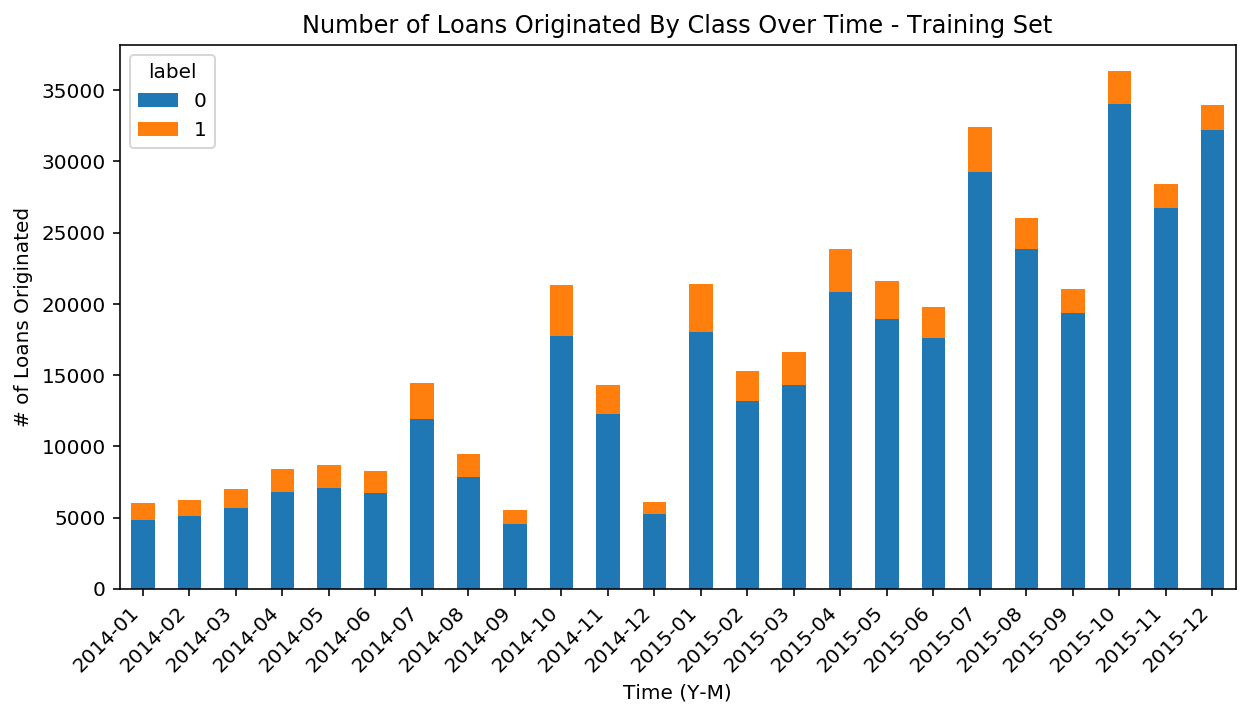

In [76]:
#create plot to visualize number of loans originated by class over time
issue_dates_train = df.groupby(['issue_date', 'label']).count().unstack()['member_id']
ax = issue_dates_train.plot(kind='bar', stacked=True, title='Number of Loans Originated By Class Over Time - Training Set', figsize=(10,5))
plt.xticks(
    rotation=45,
    horizontalalignment='right'
)
ax.set_xlabel('Time (Y-M)')
ax.set_ylabel('# of Loans Originated');

Some features that could be valuable based on this plot would be around rolling averages of number of issued and defaulted loans from the prevailing months. Unfortunately, I was not able to create these in time for modeling, but could be something to pursue in the future. 

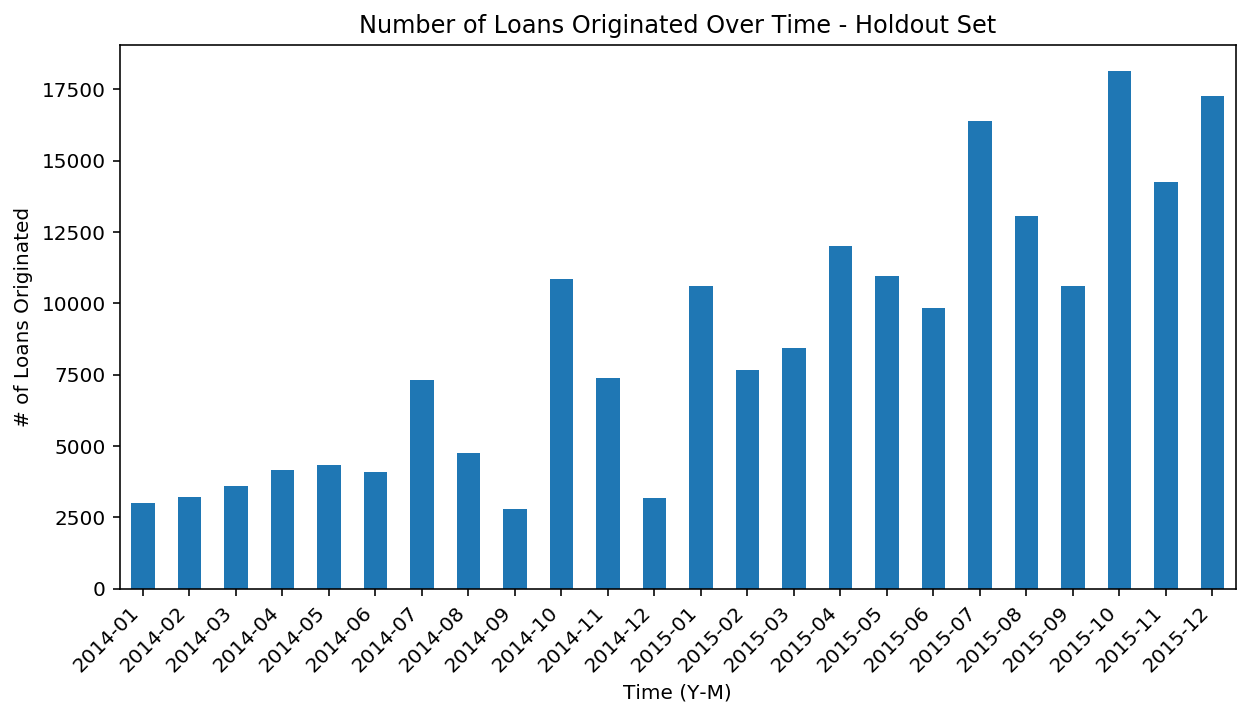

In [78]:
#create plot to visualize number of loans originated over time
issue_dates_holdout = holdout_data['issue_date'].value_counts().sort_index()
ax = issue_dates_holdout.plot(kind='bar', title='Number of Loans Originated Over Time - Holdout Set', figsize=(10,5))
plt.xticks(
    rotation=45,
    horizontalalignment='right'
)
ax.set_xlabel('Time (Y-M)')
ax.set_ylabel('# of Loans Originated');

### Import External Data Set (Libor Rates), Create Rolling Features, & Merge to Main Data Set 
Feeling ambitious, I decided to tackle the first bonus challenge and bring in an external dataset to utilize for feature engineering and modeling. I chose the one-year Libor rates over this time period, as loans are typically priced based on a benchmark rate, such as Libor. I’ve also created some rolling average features of the Libor rate prior to the loan being issued. I could have also implemented forward looking rates, which may have been highly predictive of defaults, especially if these are variable rate loans. However, in the real world setting, I would not have access to these forward looking rates, so I elected not to implement them. Later on, I use the Libor rate for an additional feature, that being the difference between the interest rate on the issued loan and the current Libor rate. This turns out to be a highly predictive feature for my final model. 

In [37]:
#source: https://fred.stlouisfed.org/series/USD12MD156N
libor_rates = pd.read_csv('USD12MD156N.csv', parse_dates=['DATE']) #import Libor data
libor_rates.columns = ['date', 'libor_rate'] #rename columns
libor_rates = libor_rates[libor_rates['libor_rate'] != '.'] #eliminate values without actual rate
libor_rates['libor_rate'] = libor_rates['libor_rate'].astype(float) #change datatype of rate column
libor_rates['date'] = libor_rates['date'].dt.to_period('M') #match date to issue date for joining
libor_rates = libor_rates.groupby('date').mean() #take the average rate over the motnh

#computer rolling averages 
for i in [3,6,12]: #set intervals for rolling average calculation
    libor_rates['libor_rate' + '_rolling_' + str(i)] = libor_rates['libor_rate'].rolling(window=i).mean() #create column with interval for each computation     
    
libor_rates.dropna(inplace=True) #drop null values (values prior to 2014)

libor_rates.head()

,libor_rate,libor_rate_rolling_3,libor_rate_rolling_6,libor_rate_rolling_12
date,,,,
2013-12,0.579045,0.594501,0.631331,0.682804
2014-01,0.575300,0.580340,0.613240,0.662890
2014-02,0.554605,0.569650,0.594349,0.645617
2014-03,0.557143,0.562349,0.578425,0.630785
2014-04,0.550005,0.553918,0.567129,0.616883


In [38]:
#merge Libor data across both datasets
df = df.merge(libor_rates, left_on='issue_date', right_index=True)
holdout_data = holdout_data.merge(libor_rates, left_on='issue_date', right_index=True)

### Recommendations for Better Partitioning 
The second bonus challenge for this section was to recommend a better partitioning of the data storage. I would say that the system should be structured more in a relational database format, where different components of the larger dataset are housed in separate tables and Member ID can serve as the linkage between the tables. For instance, information particular to a loan should be a single row in a loan table versus applicant background information which can be in its own table. This would reconcile the missing Loan ID, which hindered the deduplication efforts. I may also store information that can be grouped together separately, such as all credit versus banking information, as those items in those rows would tend to get updated at the same time and so it would be easier to remove older records when new information is ingested. 

# Feature Engineering
The feature engineering section focuses mainly on data cleanup and creating some additional features for modeling. I've divided it along those lines, with deduplication and replacing missing values taken care of first and then plotting and creating new features. 

### Deduplication
There was an incredible amount of duplicated values, maybe more than I have ever seen. Over half the training set was a complete or near duplicate. The troublsome part was mainly the near duplications, which I didn't discover until later in my process. These appeared to be the same values visually, but were actually slightly different values (e.g. feature values would display in the dataframe as the same but when inspected closer, one would contain more digits than the other. After looking at a few closely, I ended up droping all rows that duplicated the information related to the applicant rather than that which is specific to the loan being issued. I only realized this was an issue when I was going to engineer a feature around how many loans each applicant had been issued at the time that the current loan was being issued. After cleaning everything up, the Member ID were all unique, so this no longer applied, but the function is still included below in case the situation changes as more data becomes available. Including the Loan ID would help in this effort.

In [39]:
df.shape

(831170, 68)

In [40]:
df.duplicated().sum()

181311

In [41]:
df.drop_duplicates(inplace=True)
df.shape

(649859, 68)

In [42]:
sum(df['member_id'].value_counts() > 1)/df.shape[0]

0.36525615556605356

In [43]:
sum(df['member_id'].value_counts() > 1)

237365

In [44]:
df.duplicated(subset=['member_id', 'issue_date', 'int_rate', 'installment']).sum()

237365

In [45]:
df.drop_duplicates(subset=['member_id', 'issue_date', 'int_rate', 'installment'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(412494, 68)

In [46]:
# function to create a feature for number of loans issued in this dataset, which was never used
# def return_number_of_existing_loans(dataframe, index_num, member_id):
#     previous_ids = dataframe.iloc[:index_num, 1].values
#     return list(previous_ids).count(member_id)

### Handle Missing Values
Four columns had missing values, which aligned to what was in the data dictionary. For the two with greater than 60% missing, I decided to drop those columns. This is too large of missing values to estimate and the values could not be derived from other features. 

The other two features were 'mths_since_recent_inq' (Months since most recent inquiry) and 'mths_since_recent_bc' (Months since most recent bankcard account opened). I first attempted to fill in Months since most recent inquiry with values derived 'inq_last_6mths' (Number of credit inquiries within the past 6 months (excluding auto and mortgage)). For instance, I thought if there was a inquiry in the past 6 months, I could fill the missing values with six. However, I quickly realized that this wasn't the case, and that many records with an inquire in the past six months had greater than six months in the Months since most recent inquiry column. I went through a similar process with 'mths_since_recent_bc' but was not successful there either. 

I ended up using IterativeImputer from the fancyimpute package to fill in those values. IterativeImputer uses a similar strategy as MICE to impute missing values based on creating a Bayesian ridge regression model trained on other feature values. I hadn't used this approach before but wanted to try it out in this case. I first attempted to use the KNN class to make these imputations, but it does not currently have a transform method, so there would be data leakage between the training and holdout sets. I plotted the two features before and after the imputation and was generally happy with the results. Clearly, 'mths_since_recent_inq' has more values being estimated, so the distribution does change a bit after the imputation process. I decided to keep the original columns as well and fill them with the median values later on, which will allow me to see what approach performed better. 

In [47]:
df.isnull().sum()[df.isnull().sum() > 0] * 100/df.shape[0]

mths_since_recent_bc              0.888255 
mths_since_recent_bc_dlq          74.181685
mths_since_recent_inq             11.047191
mths_since_recent_revol_delinq    64.068083
dtype: float64

In [48]:
holdout_data.isnull().sum()[holdout_data.isnull().sum() > 0] * 100/holdout_data.shape[0]

mths_since_recent_bc              0.919665 
mths_since_recent_bc_dlq          74.140130
mths_since_recent_inq             11.121645
mths_since_recent_revol_delinq    64.041137
dtype: float64

In [49]:
data_dictionary[data_dictionary['# NA Values'].notnull()]

,Variable Name,Meaning,# NA Values
17,mths_since_recent_inq,Months since most recent inquiry.,yes
44,mths_since_recent_bc,Months since most recent bankcard account opened.,yes
45,mths_since_recent_bc_dlq,Months since most recent bankcard delinquency,yes
46,mths_since_recent_revol_delinq,Months since most recent revolving delinquency.,yes


In [50]:
df.drop(['mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq'], axis=1, inplace=True)

In [51]:
holdout_data.drop(['mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq'], axis=1, inplace=True)

In [52]:
df.isnull().sum()[df.isnull().sum() > 0] * 100/df.shape[0]

mths_since_recent_bc     0.888255 
mths_since_recent_inq    11.047191
dtype: float64

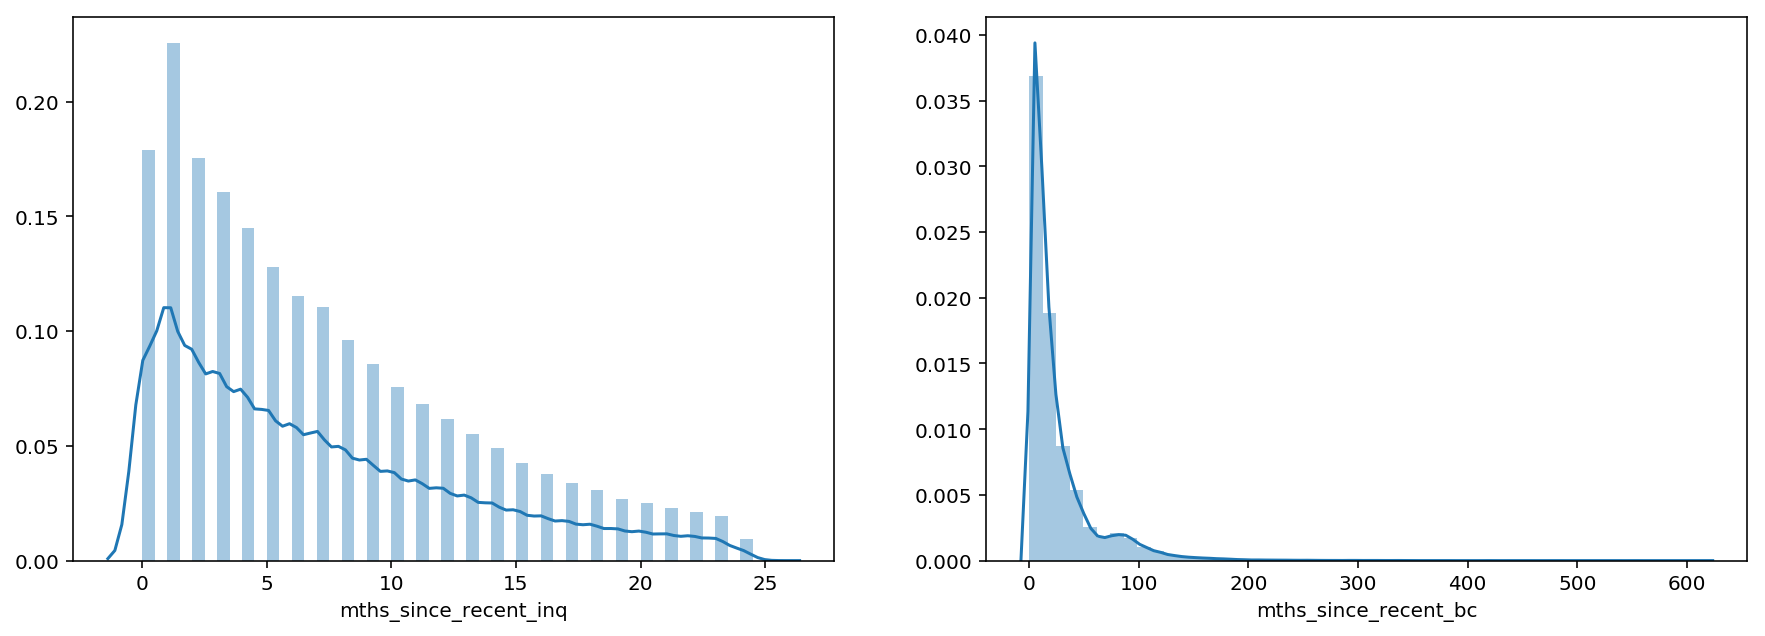

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(df['mths_since_recent_inq'].dropna(), ax=ax[0])
sns.distplot(df['mths_since_recent_bc'].dropna(), ax=ax[1]);

In [54]:
imputer = IterativeImputer()
numerical_cols_for_missing_values = [column for column in df.columns if (df[column].dtype in ['float64', 'int64']) & (column not in ['label', 'member_id'])]
df_filled = imputer.fit_transform(df[numerical_cols_for_missing_values])
df_filled = pd.DataFrame(df_filled, columns=numerical_cols_for_missing_values)
df_original_cols = df[['mths_since_recent_inq', 'mths_since_recent_bc']]
df_original_cols.columns = ['mths_since_recent_inq_original', 'mths_since_recent_bc_original']
df = pd.concat([df_filled, df[[column for column in df.columns if column not in numerical_cols_for_missing_values]], df_original_cols], axis=1)

In [55]:
df.shape

(412494, 68)

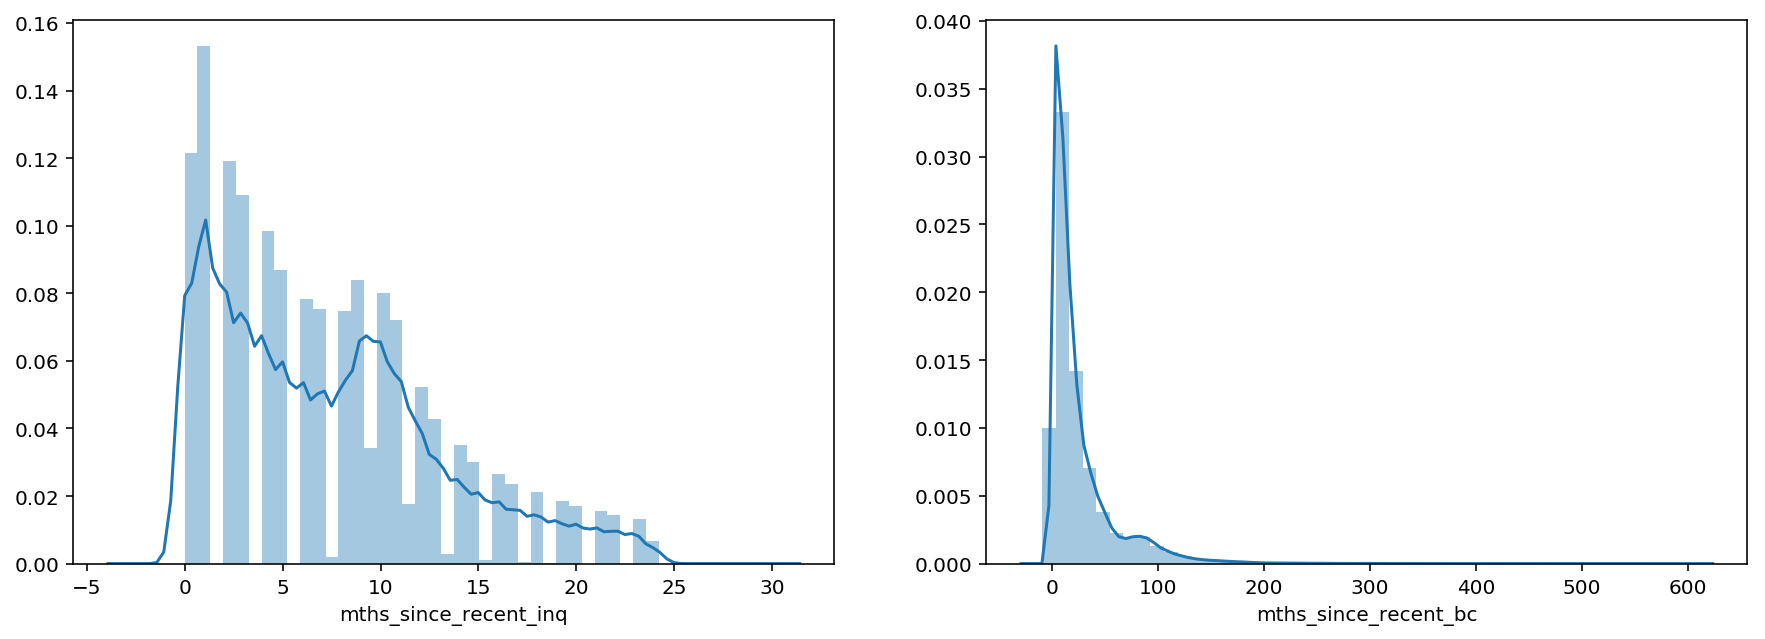

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(df['mths_since_recent_inq'], ax=ax[0])
sns.distplot(df['mths_since_recent_bc'], ax=ax[1]);

In [57]:
holdout_data.shape

(207793, 65)

In [58]:
holdout_filled = imputer.transform(holdout_data[numerical_cols_for_missing_values])
holdout_filled = pd.DataFrame(holdout_filled, columns=numerical_cols_for_missing_values)
holdout_original_cols = holdout_data[['mths_since_recent_inq', 'mths_since_recent_bc']]
holdout_original_cols.columns = ['mths_since_recent_inq_original', 'mths_since_recent_bc_original']
holdout_data = pd.concat([holdout_filled, holdout_data[[column for column in holdout_data.columns if column not in numerical_cols_for_missing_values]], holdout_original_cols], axis=1)

In [59]:
null_cols = df_original_cols.columns

In [60]:
null_cols

Index(['mths_since_recent_inq_original', 'mths_since_recent_bc_original'], dtype='object')

In [61]:
assert df[[i for i in df.columns if i not in null_cols]].isnull().sum().sum() == 0
assert holdout_data[[i for i in holdout_data.columns if i not in null_cols]].isnull().sum().sum() == 0

### Plot Data for Further Inspection
Below, I've plotted the distributions of the numerical features for both the training and holdout set. This lead to a number of insights, including binning a few of the features and ensuring that I scaled the remaining features in a pipeline for any linear based model. This can be seen from the bimodal distributions of some of the features with groupings at the endpoints (typically values 0 and 500). 

Interestingly, as with the plot above, the distributions of each feature are nearly identical in the training and holdout sets. Again, I am not sure what to make of this, whether it is caused by how the holdout examples were sampled or if the data is synthetic. 

In [62]:
#create list of relevant features to plot
cols_to_plot = [column for column in df.columns if 
                (df[column].dtype in ['float64', 'int64']) 
                & (column not in ['label', 'member_id'])
                & (column not in null_cols)]

In [63]:
fig, ax = plt.subplots(len(cols_to_plot), 2, figsize=(20, 300))

#iterate through list and plot both training and holdout data
for i,j in enumerate(cols_to_plot):
    ax[i,0].set_title(str(j) + ', train_data', fontsize=10)
    sns.distplot(df[j], kde=False, ax=ax[i,0], color='r')
    ax[i,1].set_title(str(j) + ', holdout data', fontsize=10)
    sns.distplot(holdout_data[j], kde=False, ax=ax[i,1], color='g');

### Create New Features
When inspecting the plots above, I noticed a few features with a bimodal distribution with a large concentration at the value 5000. Since this represented an amount of months, those values were clearly outliers. I decided to bin those columns as categorical features for my models. Even though the Random Forest model I will use later will do this type of partitioning on its own, I decided that there is an explicit signal with these features that I would like to try and capture that. I will leave the original values in place to see what performs better in regards to feature importance. There were a few other features with a similar looking distribution, however these values were typically within reason (i.e. values 0 and 100) so I have decided to leave these as they are and let the Random Forest model learn the correct partitioning of these features. 

I also created a few more features below, including the difference in interest rate and the Libor rate and a monthly debt payment derived from the debt-to-income (DTI) ratio and annual income (DTI is the percentage of your gross monthly income debt payments). The difference between the loan's interest rate and the Libor rate turned out to be the most impactful feature for both models, with clear distinction betweeen the classes in the plot below.

Again, some features that could have been valuable but that I didn't have enough time to create would have been rolling averages of number of issued and defaulted loans from the prevailing months. I may pursue these in the future and if provided with data from more months, I think this could be very valuable features. 

In [19]:
cols_to_bin = [i for i in df.columns if df[i].max() == 5000] #bin cols with max values of 5000
binned_col_names = ['binned_' + i for i in cols_to_bin] #create list of new column names

In [65]:
def feature_engineering(dataframe):
    for i,j in zip(binned_col_names, cols_to_bin):
        dataframe[j] = dataframe[j].astype(int)
        dataframe.loc[dataframe[j] == 5000, j] = np.nan #set 5000 value to NaN for now
        dataframe[i] = pd.qcut(dataframe[j], 5).values.add_categories('over_5000') #create quantile cuts (evenly distributed # of loans per category) and include 5000 column
        dataframe[i].fillna('over_5000', inplace=True) #set 5000 values to appropriate column
        dataframe[i] = dataframe[i].astype(str) 
        dataframe[i] = dataframe[i].map((lambda x: i + '_' + re.sub(r'\W+', '_', x).strip('_'))) #replace non-alpha numeric characters with '_' so these features can be extracted later
        dataframe[j].fillna(5000, inplace=True) #replace values from before
        
    dataframe.loc[dataframe['emp_length'] == -1, 'emp_length'] = 0 #fix employment length from less than a year to 0 years, maintains its ordinality

    dataframe['libor_difference'] = dataframe['int_rate'] - dataframe['libor_rate'] #calculate different between loan's interest rate and libor rate

    dataframe['monthly_debt'] = dataframe.apply(lambda x: (x['annual_inc']/12) * (x['dti']/100), axis=1) #extract monthly debt payments from DTI and annual income
    
    return dataframe

In [66]:
#apply feature engineering across each dataset
df = feature_engineering(df)
holdout_data = feature_engineering(holdout_data)

In [67]:
#ensure create feature columns are in the dataset
[i for i in df.columns if i not in original_cols_in_data_dictionary]

['libor_rate',
 'libor_rate_rolling_3',
 'libor_rate_rolling_6',
 'libor_rate_rolling_12',
 'label',
 'issue_date',
 'mths_since_recent_inq_original',
 'mths_since_recent_bc_original',
 'binned_mths_since_last_delinq',
 'binned_mths_since_last_record',
 'binned_mths_since_last_major_derog',
 'binned_mo_sin_old_il_acct',
 'libor_difference',
 'monthly_debt']

In [68]:
#check that all columns found in training data are in holdout set (except for target)
cols_not_in_holdout = [i for i in df.columns if i not in holdout_data.columns]
assert cols_not_in_holdout == ['label']

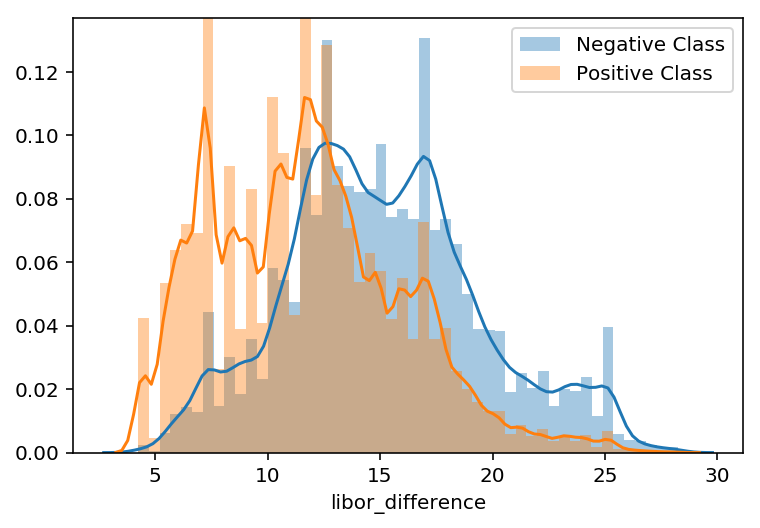

In [69]:
#plot created feature
sns.distplot(df[df['label'] == 1]['libor_difference'], label='Negative Class')
sns.distplot(df[df['label'] == 0]['libor_difference'], label='Positive Class')
plt.legend();

The difference between interest rate and Libor rate already looks like it will be a predictive feature, as there is clear distinction between the different classes.

In [32]:
#convert issue date to string to use as categorical features later
df['issue_date'] = df['issue_date'].astype(str)
holdout_data['issue_date'] = holdout_data['issue_date'].astype(str)

# Quantitative Model
For the modeling section, I have leveraged many open-source tools to create a scalable process to complete my feature engineering (including one-hot encoding categorical features and scaling the data), divide my training into partitions for cross validation and a test set to help avoid overfitting the model, select model hyperparameters, evaluate competing models, and easily make predictions for the holdout set. 

The pipeline is composed of SampleExtractor and DenseTransformer, which enable CountVectorizer to be used for dummying features without data leakage from train to test or predict datasets. In this case, there are no categorical values that are not found in both sets, but it is still a valid technique to employ. For the linear-based classification model that I used (SGDClassifier), I scaled the features in the pipeline using StandardScaler as this helps the gradient descent algorithm converge faster and makes the coefficients more comparable for feature importance. 

In addition to the pipeline, I used Train Test Split, StratifiedKFold, and BayesSearchCV (Cross Validation) to help determine model hyperparameters. Train test splitting allows for a holdout test set to be created to be scored after the best model hyperparameters are selected through a Bayesian Optimization process. This technique utilizes a what is called a 'surrogate' model, which maps a probabilistic function to a given objective function to iteratively improve the model hyperparameters and overall model performance based on past results. StratifiedKFold ensures that the classes are balanced in each CV set, thereby ensuring that the model is trained equally for each class. Cross validation and StratifiedKFold also both ensure that overfitting is reduced. 

To address the imbalanced classes, I first tried to use SMOTE, or Synthetic Minority Over-sampling Technique, to generate new samples of my minority class to use for modeling. However, this addition to my pipeline added processing time and I could not afford to employ this technique. I ended undersampling the majority class (non-defaulted loans) as this helped me reduce the size of my training dataset and have a balanced representation of each class. This is important so that the model can learn how to make predictions for both classes, rather than just predicting most or all loans as not likely to default. 

For the models, I choose to use a tree-based random forest model and a linear-based model (SGDClassifier). The SGDClassifier model is very similar to a logistic regression model, however it utilizes stochastic gradient descent to train the model faster with minor sacrifices in accuracy. Ultimately, the random forest model performed better on the test set compared with the SGD Model. This is likely due to the partitioning of the bimodal distributions of feature values highlighted above, among other factors. The models were also only trained for 20 iterations of the Bayesian Optimization and better performance could be expected with more training time (unfortuately I ran out of time before the deadline!). 

The models are evaluated using the metric Area Under the Receiver Operating Characteristic Curve (ROC AUC). The ROC AUC score is based on iterating through different thresholds of probabilities and seeing how the model will predict cases. The metric is based on model predictions evaluated by the true positive and false positive rates at each threshold.I selected this metric because it helps create a model that balances the issue with making false predictions for either class (loss protection vs. revenue growth). In reality, a sophisticated cost-benefit will be coupled with this sort of model, but for our purposes the ROC AUC score is a valid first step down this path. Also, since we balanced the classes in our data, we minimized the drawbacks that imbalanced classes can have on this metric.  

In [33]:
df['label'].value_counts()/df.shape[0]

0    0.882107
1    0.117893
Name: label, dtype: float64

In [34]:
df['label'].value_counts()

0    363864
1    48630 
Name: label, dtype: int64

In [35]:
undersample_ratio = df['label'].value_counts()[1] /df['label'].value_counts()[0] 
undersample_ratio #amount to undersample majority class

0.13364883582877118

In [36]:
df_final = df[df['label'] == 0].sample(frac=undersample_ratio, random_state=1) #random sample of majority class

In [37]:
df_final = pd.concat([df_final, df[df['label'] == 1]]) #concatenate the two dataframes with even class distribution

In [38]:
df_final.shape

(97260, 74)

### Create Pipeline

In [39]:
#classes necessary for treatment of both categorical and numerical data. source can be found here: https://blomadam.github.io/.
class ModelTransformer(BaseEstimator,TransformerMixin):

    def __init__(self, model=None):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return self.model.transform(X)
    
class SampleExtractor(BaseEstimator, TransformerMixin):
    """Takes in varaible names as a **list**"""

    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column names to extract

    def transform(self, X, y=None):
        if len(self.vars) > 1:
            return pd.DataFrame(X[self.vars]) # where the actual feature extraction happens
        else:
            return pd.Series(X[self.vars[0]])

    def fit(self, X, y=None):
        return self  # generally does nothing
    
    
class DenseTransformer(BaseEstimator,TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [40]:
continuous_cols = [col for col in df.columns if (df[col].dtype in ['float64', 'int64']) & (col not in ['label', 'member_id'])] #create list of numerical columns excluding label and member id

In [41]:
feature_cols = continuous_cols + binned_col_names + ['issue_date'] #create list of all feature columns

In [42]:
[i for i in df.columns if i not in feature_cols]

['member_id', 'label']

In [43]:
#create features and target data from the train data set
X = df_final[feature_cols]
y = df_final['label']

X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0) #train test split 
strat_kfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=0) #stratified kfolds for cross validation

In [44]:
#create pipeline objects for each categorical feature
date = Pipeline([
              ('text',SampleExtractor(['issue_date'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
b_mo_sin_old_il_acct = Pipeline([
              ('text',SampleExtractor(['binned_mo_sin_old_il_acct'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
b_mths_since_last_major_derog = Pipeline([
              ('text',SampleExtractor(['binned_mths_since_last_major_derog'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
b_mths_since_last_record = Pipeline([
              ('text',SampleExtractor(['binned_mths_since_last_record'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
b_mths_since_last_delinq = Pipeline([
              ('text',SampleExtractor(['binned_mths_since_last_delinq'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])

### Train Models

In [45]:
#construct pipeline for random forest
#smote was taken out due to time constraints
pipeline_rf = Pipeline([
    ('features', FeatureUnion([
        ('date', date),
        ('b_mo_sin_old_il_acct', b_mo_sin_old_il_acct),
        ('b_mths_since_last_major_derog', b_mths_since_last_major_derog),
        ('b_mths_since_last_record', b_mths_since_last_record),
        ('b_mths_since_last_delinq', b_mths_since_last_delinq),
        ('cont_features', Pipeline([ 
                      ('continuous', SampleExtractor(continuous_cols))
                      ])),
        ])),
        ('imputer', SimpleImputer(strategy='median')),
#         ('sampling', SMOTE(sampling_strategy='minority', random_state=0)),
        ('model', RandomForestClassifier(max_samples=.25, class_weight= 'balanced', oob_score=True, random_state=2, verbose=1, n_jobs=-1)),
])


rf_search = {
    'model__n_estimators':(25, 500),
    'model__max_features':(5, 50),
    'model__min_samples_leaf':(1, 10),
    'model__min_samples_split': (2, 10), 
    'model__max_depth':(3,12),
    'model__criterion': ['gini', 'entropy']
}


# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    best_params = searchcv.best_params_
    print("best score: %s" % score)
    print("best params: %s" % best_params)

    
searchcv = BayesSearchCV(
    pipeline_rf, 
    [(rf_search, 20)], #20 iterations due to time constraints
    scoring = 'roc_auc', 
    cv=strat_kfolds, 
    n_jobs=-1
)

searchcv.fit(X_train, y_train, callback=on_step)

best score: 0.7490758345603529
best params: OrderedDict([('model__criterion', 'gini'), ('model__max_depth', 10), ('model__max_features', 40), ('model__min_samples_leaf', 6), ('model__min_samples_split', 10), ('model__n_estimators', 143)])
best score: 0.7490758345603529
best params: OrderedDict([('model__criterion', 'gini'), ('model__max_depth', 10), ('model__max_features', 40), ('model__min_samples_leaf', 6), ('model__min_samples_split', 10), ('model__n_estimators', 143)])
best score: 0.7505023239793158
best params: OrderedDict([('model__criterion', 'entropy'), ('model__max_depth', 11), ('model__max_features', 46), ('model__min_samples_leaf', 6), ('model__min_samples_split', 5), ('model__n_estimators', 257)])
best score: 0.7505023239793158
best params: OrderedDict([('model__criterion', 'entropy'), ('model__max_depth', 11), ('model__max_features', 46), ('model__min_samples_leaf', 6), ('model__min_samples_split', 5), ('model__n_estimators', 257)])
best score: 0.7505023239793158
best para

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
              error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('features',
                                         FeatureUnion(n_jobs=None,
                                                      transformer_list=[('date',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('text',
                                                                                          SampleExtractor(vars=['issue_date'])),
                                                                                         ('dummify',
                                                                                          CountVectorizer(analyzer='word',
                                                                                                

In [49]:
# #save best estimator and pickle model to avoid rerunning 
rf_model = searchcv.best_estimator_

# #pickle/unpickle model below 
modelfilename= 'rf_model.sav'
pickle.dump(rf_model, open(modelfilename, 'wb'))

# rf_model = pickle.load(open('rf_model.sav', 'rb'))

In [59]:
#create pipeline for the SGDClassifier
pipeline_sgd = Pipeline([
    ('features', FeatureUnion([
        ('date', date),
        ('b_mo_sin_old_il_acct', b_mo_sin_old_il_acct),
        ('b_mths_since_last_major_derog', b_mths_since_last_major_derog),
        ('b_mths_since_last_record', b_mths_since_last_record),
        ('b_mths_since_last_delinq', b_mths_since_last_delinq),
        ('cont_features', Pipeline([ 
                      ('continuous', SampleExtractor(continuous_cols))
                      ])),
        ])),
        ('imputer', SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy='minority', random_state=0)),
        ('sgd', SGDClassifier(loss='log', max_iter=1000, random_state=0, n_jobs=-1)),
])

sgd_search={'sgd__penalty':  ['l1', 'l2', 'elasticnet'],
            'sgd__alpha': (1e-9, 1.0, 'log-uniform'),
            'sgd__l1_ratio':(0.01, 1.0, 'uniform')}

# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    best_params = searchcv.best_params_
    print("best score: %s" % score)
    print("best params: %s" % best_params)
    
searchcv = BayesSearchCV(
    pipeline_sgd, 
    [(sgd_search, 20)], 
    scoring = 'roc_auc', 
    cv=strat_kfolds, 
    n_jobs=-1
)


searchcv.fit(X_train, y_train, callback=on_step)

best score: 0.7461158086600618
best params: OrderedDict([('sgd__alpha', 0.0072744757295768285), ('sgd__l1_ratio', 0.8682221864604651), ('sgd__penalty', 'l1')])
best score: 0.7461158086600618
best params: OrderedDict([('sgd__alpha', 0.0072744757295768285), ('sgd__l1_ratio', 0.8682221864604651), ('sgd__penalty', 'l1')])
best score: 0.7461158086600618
best params: OrderedDict([('sgd__alpha', 0.0072744757295768285), ('sgd__l1_ratio', 0.8682221864604651), ('sgd__penalty', 'l1')])
best score: 0.7465576815541646
best params: OrderedDict([('sgd__alpha', 0.5091641877091051), ('sgd__l1_ratio', 0.563991909209465), ('sgd__penalty', 'l2')])
best score: 0.7465576815541646
best params: OrderedDict([('sgd__alpha', 0.5091641877091051), ('sgd__l1_ratio', 0.563991909209465), ('sgd__penalty', 'l2')])
best score: 0.7465576815541646
best params: OrderedDict([('sgd__alpha', 0.5091641877091051), ('sgd__l1_ratio', 0.563991909209465), ('sgd__penalty', 'l2')])
best score: 0.7516685653120042
best params: OrderedD

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
              error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('features',
                                         FeatureUnion(n_jobs=None,
                                                      transformer_list=[('date',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('text',
                                                                                          SampleExtractor(vars=['issue_date'])),
                                                                                         ('dummify',
                                                                                          CountVectorizer(analyzer='word',
                                                                                                

In [60]:
#save best estimator and pickle model to avoid rerunning 
sgd_model = searchcv.best_estimator_

# #pickle/unpickle model below 
modelfilename= 'sgd_model.sav'
pickle.dump(sgd_model, open(modelfilename, 'wb'))

# sgd_model = pickle.load(open('sgd_model.sav', 'rb'))

### Inspect Models and Results

In [50]:
#fit on all data
rf_model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('date',
                                                 Pipeline(memory=None,
                                                          steps=[('text',
                                                                  SampleExtractor(vars=['issue_date'])),
                                                                 ('dummify',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=True,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
            

In [53]:
#extract feature importances and view top 25
feature_names = [] #create empty list
for i in [date, b_mo_sin_old_il_acct, b_mths_since_last_major_derog, b_mths_since_last_record, b_mths_since_last_delinq]: #iterate through each dummied feature
    feature_names.append(i.fit(X_train).steps[1][1].get_feature_names()) #add feature names to list
    
columns_list = [i for i in X.columns if (i not in binned_col_names) & (i != 'issue_date')] #create column list of features not dummied

feature_names.append(columns_list) #combine lists of feature names

feature_names = [i for j in feature_names for i in j] #turn list of lists into list of just feature names
    
feature_importances = pd.DataFrame(feature_names, rf_model.steps[2][1].feature_importances_.tolist(),columns=['Feature'])
feature_importances.reset_index(inplace=True)
feature_importances.rename({'index':'Feature Importance'}, axis=1, inplace=True)

feature_importances.sort_values(by='Feature Importance', ascending=False)[:25]

,Feature Importance,Feature
103,0.193572,libor_difference
38,0.096824,int_rate
40,0.039732,sub_grade
58,0.030673,acc_open_past_24mths
99,0.024322,libor_rate_rolling_6
98,0.022925,libor_rate_rolling_3
97,0.022255,libor_rate
87,0.021519,tot_hi_cred_lim
39,0.021229,installment
43,0.020174,dti


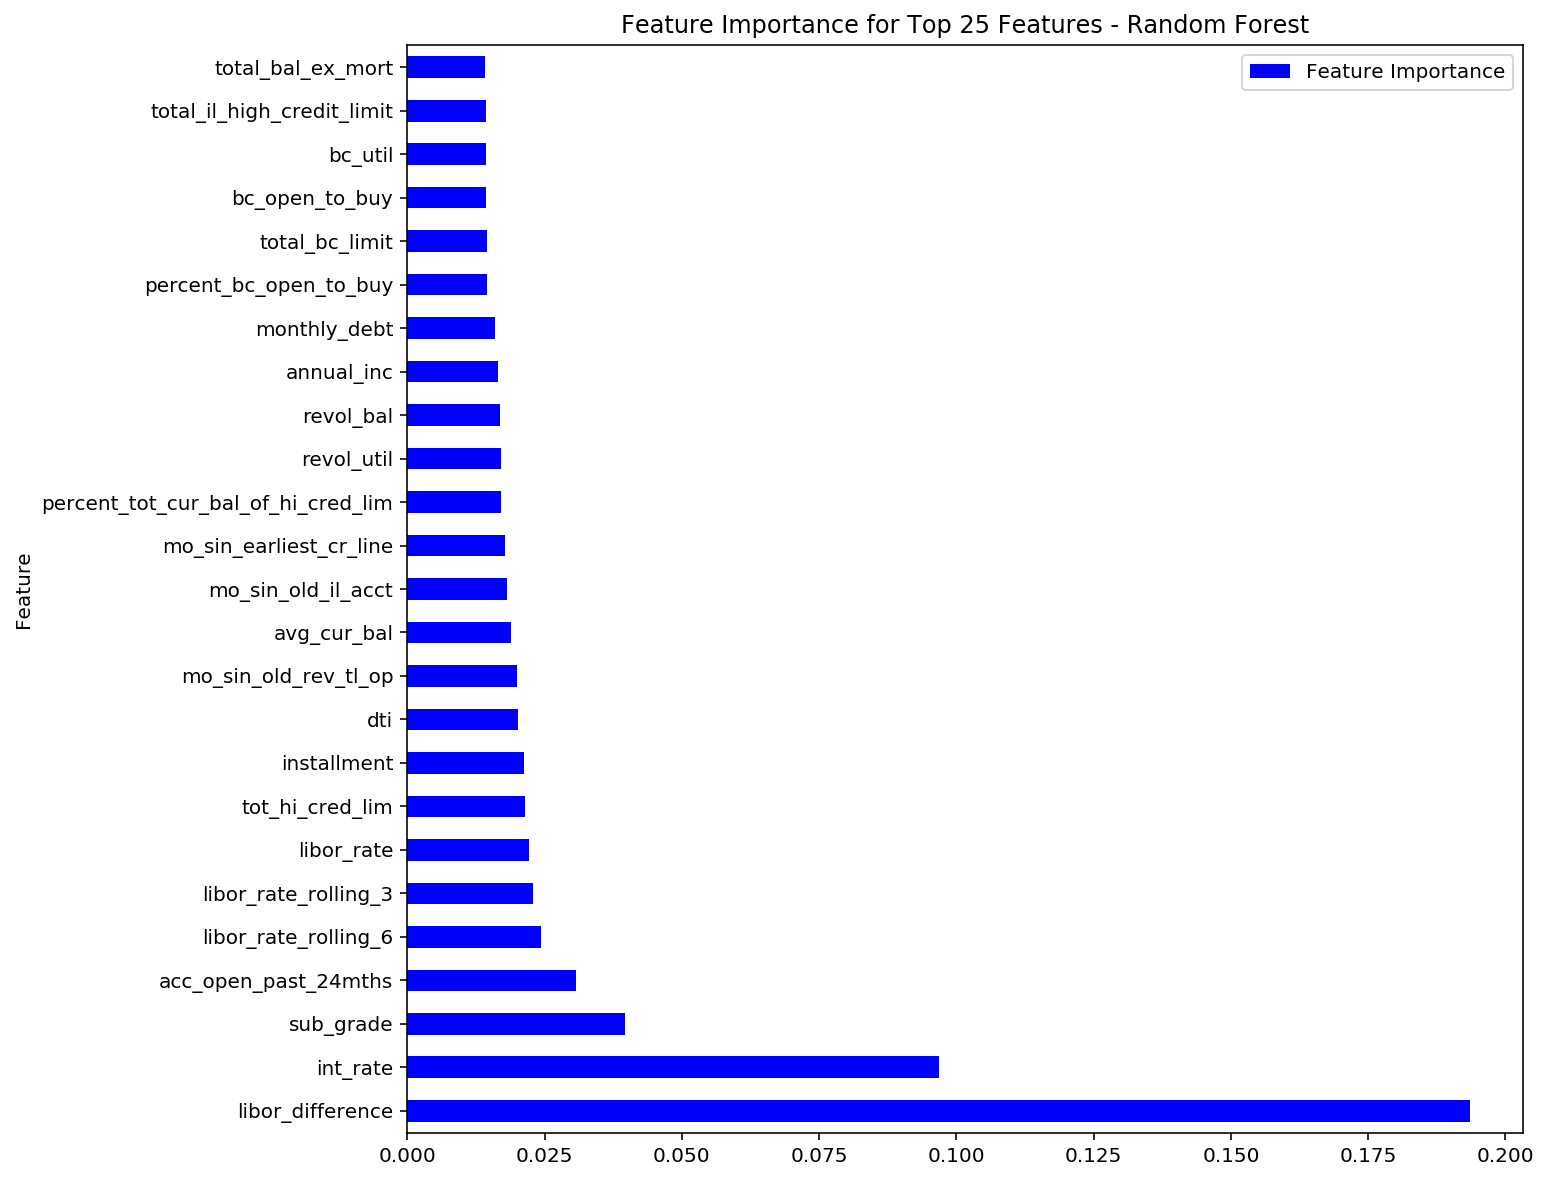

In [54]:
#Plot of top 25 features 
feature_importances.sort_values(by='Feature Importance', ascending=False)[:25].plot(y='Feature Importance',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Feature Importance for Top 25 Features - Random Forest');

In [61]:
#extract coefficients for each feature and print out the top 25
sgd_model.fit(X, y) #fit on all data

#create dataframe of coefficients
coef = pd.DataFrame(feature_names, sgd_model.steps[3][1].coef_.tolist(),columns=['Feature']) 
coef.reset_index(inplace=True)
coef.rename({'level_0':'Coefficient'}, axis=1, inplace=True)

#sort coefficients by magnitude 
coef['abs'] = coef['Coefficient'].abs()
coef25 = coef.sort_values(by='abs',ascending=False)[:25]
coef25

,Coefficient,Feature,abs
58,0.238050,acc_open_past_24mths,0.238050
103,0.227729,libor_difference,0.227729
38,0.227521,int_rate,0.227521
43,0.181338,dti,0.181338
40,0.180108,sub_grade,0.180108
90,-0.119372,total_il_high_credit_limit,0.119372
70,-0.114794,mths_since_recent_inq,0.114794
87,-0.113024,tot_hi_cred_lim,0.113024
73,-0.100507,num_actv_rev_tl,0.100507
83,0.093274,pct_tl_nvr_dlq,0.093274


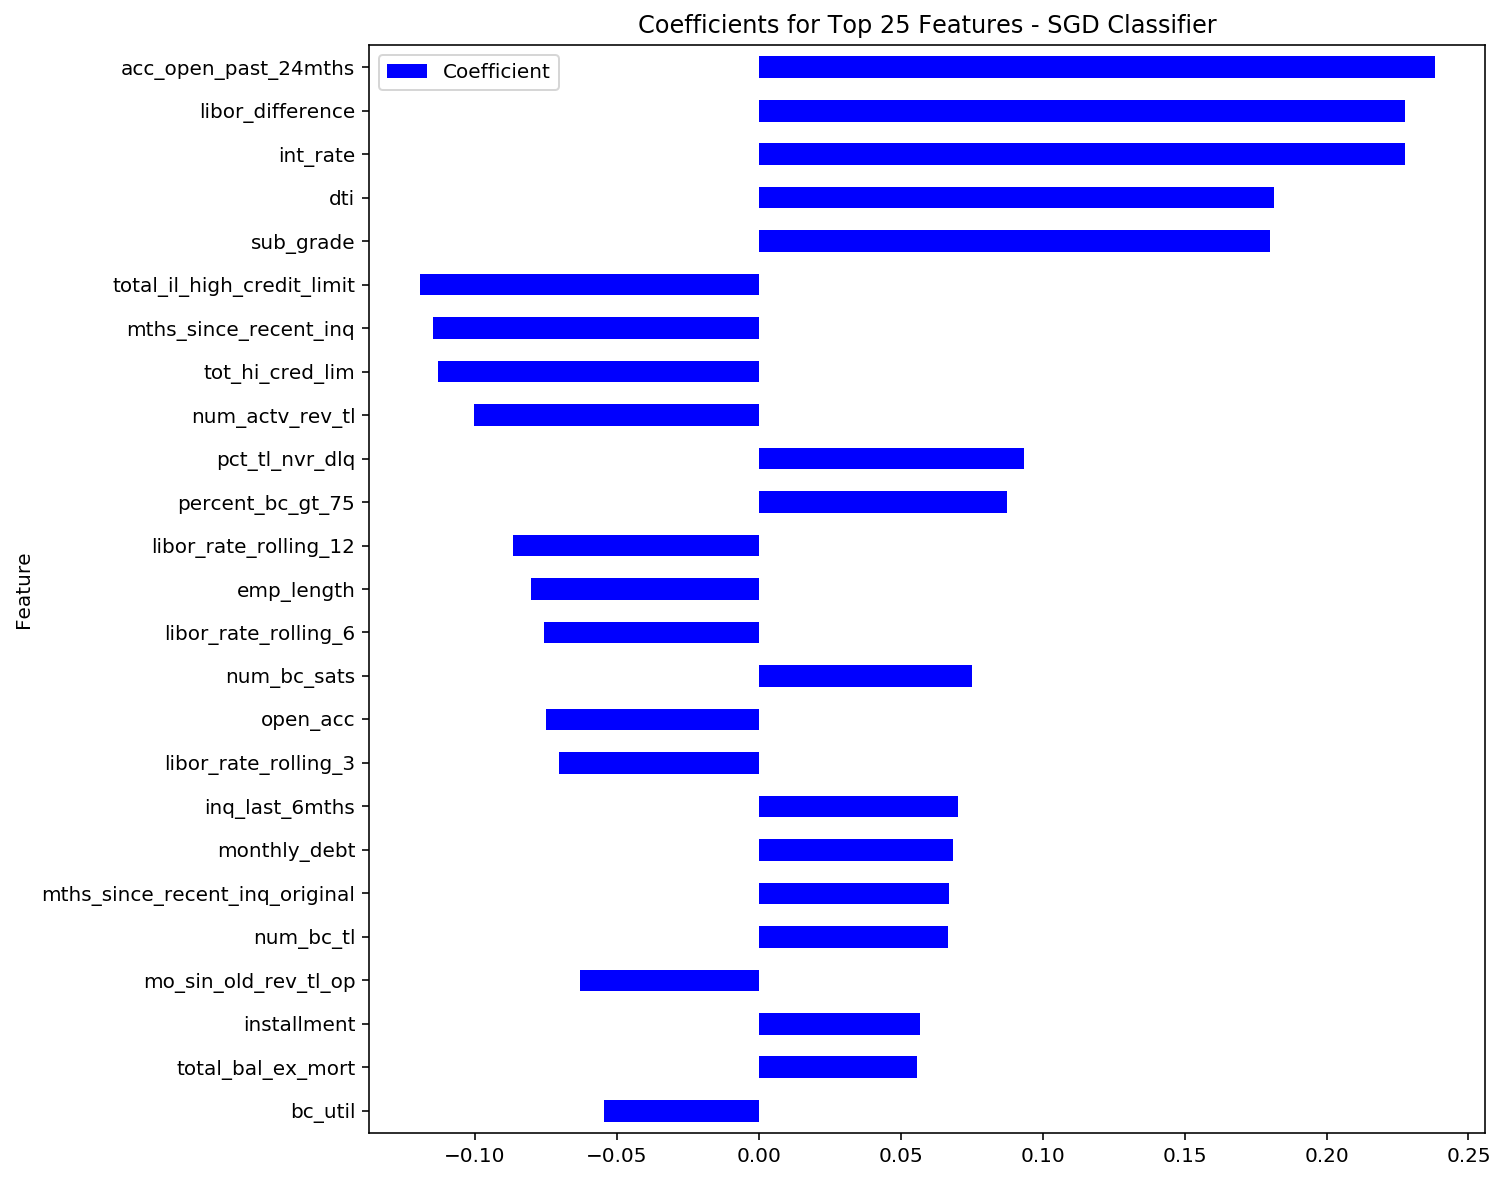

In [62]:
#create plot of coefficients
coef25.sort_values(by='abs').plot(y='Coefficient',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Coefficients for Top 25 Features - SGD Classifier');

In [63]:
#import models that were not fitted on all the train data 
rf_test = pickle.load(open('rf_model.sav', 'rb'))
sgd_test = pickle.load(open('sgd_model.sav', 'rb'))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


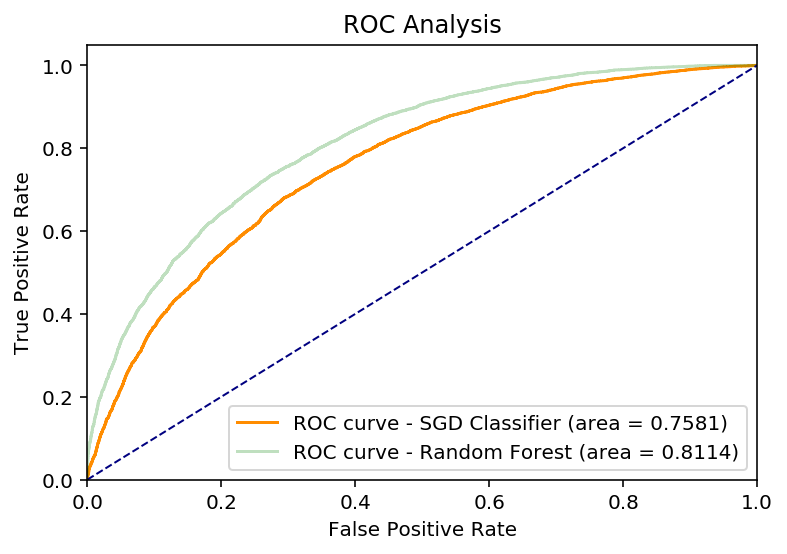

In [64]:
#use roc_curve and auc to calculate the fpr and tpr for all thresholds of the classification for each model
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_test,sgd_test.predict_proba(X_test)[:,1])
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test,rf_test.predict_proba(X_test)[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)


#plot results of each model on the same graph
plt.figure()
plt.plot(fpr_sgd, tpr_sgd, color='darkorange', label='ROC curve - SGD Classifier (area = %0.4f)' % roc_auc_sgd)
plt.plot(fpr_rf, tpr_rf, color='g', alpha=.25, label='ROC curve - Random Forest (area = %0.4f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis')
plt.legend(loc="lower right")
plt.show()

## Create Predictions for Holdout Set

In [65]:
#fit on all data
rf_model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('date',
                                                 Pipeline(memory=None,
                                                          steps=[('text',
                                                                  SampleExtractor(vars=['issue_date'])),
                                                                 ('dummify',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=True,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
            

In [75]:
holdout_out_x = holdout_data[feature_cols]

In [76]:
holdout_predictions = rf_model.predict_proba(holdout_out_x)[:,1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    3.6s finished


In [77]:
predictions_df = pd.DataFrame(holdout_predictions, columns=['prediction'])

In [78]:
predictions_df.to_csv('loan_predictions.csv')